# **Needed Libraries**

In [2]:
import os 
import itertools
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import warnings
warnings.filterwarnings('ignore') 

# **Reading the Data**

In [3]:
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
img_paths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        img_paths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(img_paths, name= 'img_paths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,img_paths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant


In [5]:
test_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
img_paths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        img_paths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(img_paths, name= 'img_paths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
test_df

,img_paths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant


# **Preprocessing**

In [7]:
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state=42)

In [8]:
# img data generator(same size)
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'img_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'img_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'img_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 1318 validated image filenames belonging to 2 classes.
Found 1319 validated image filenames belonging to 2 classes.


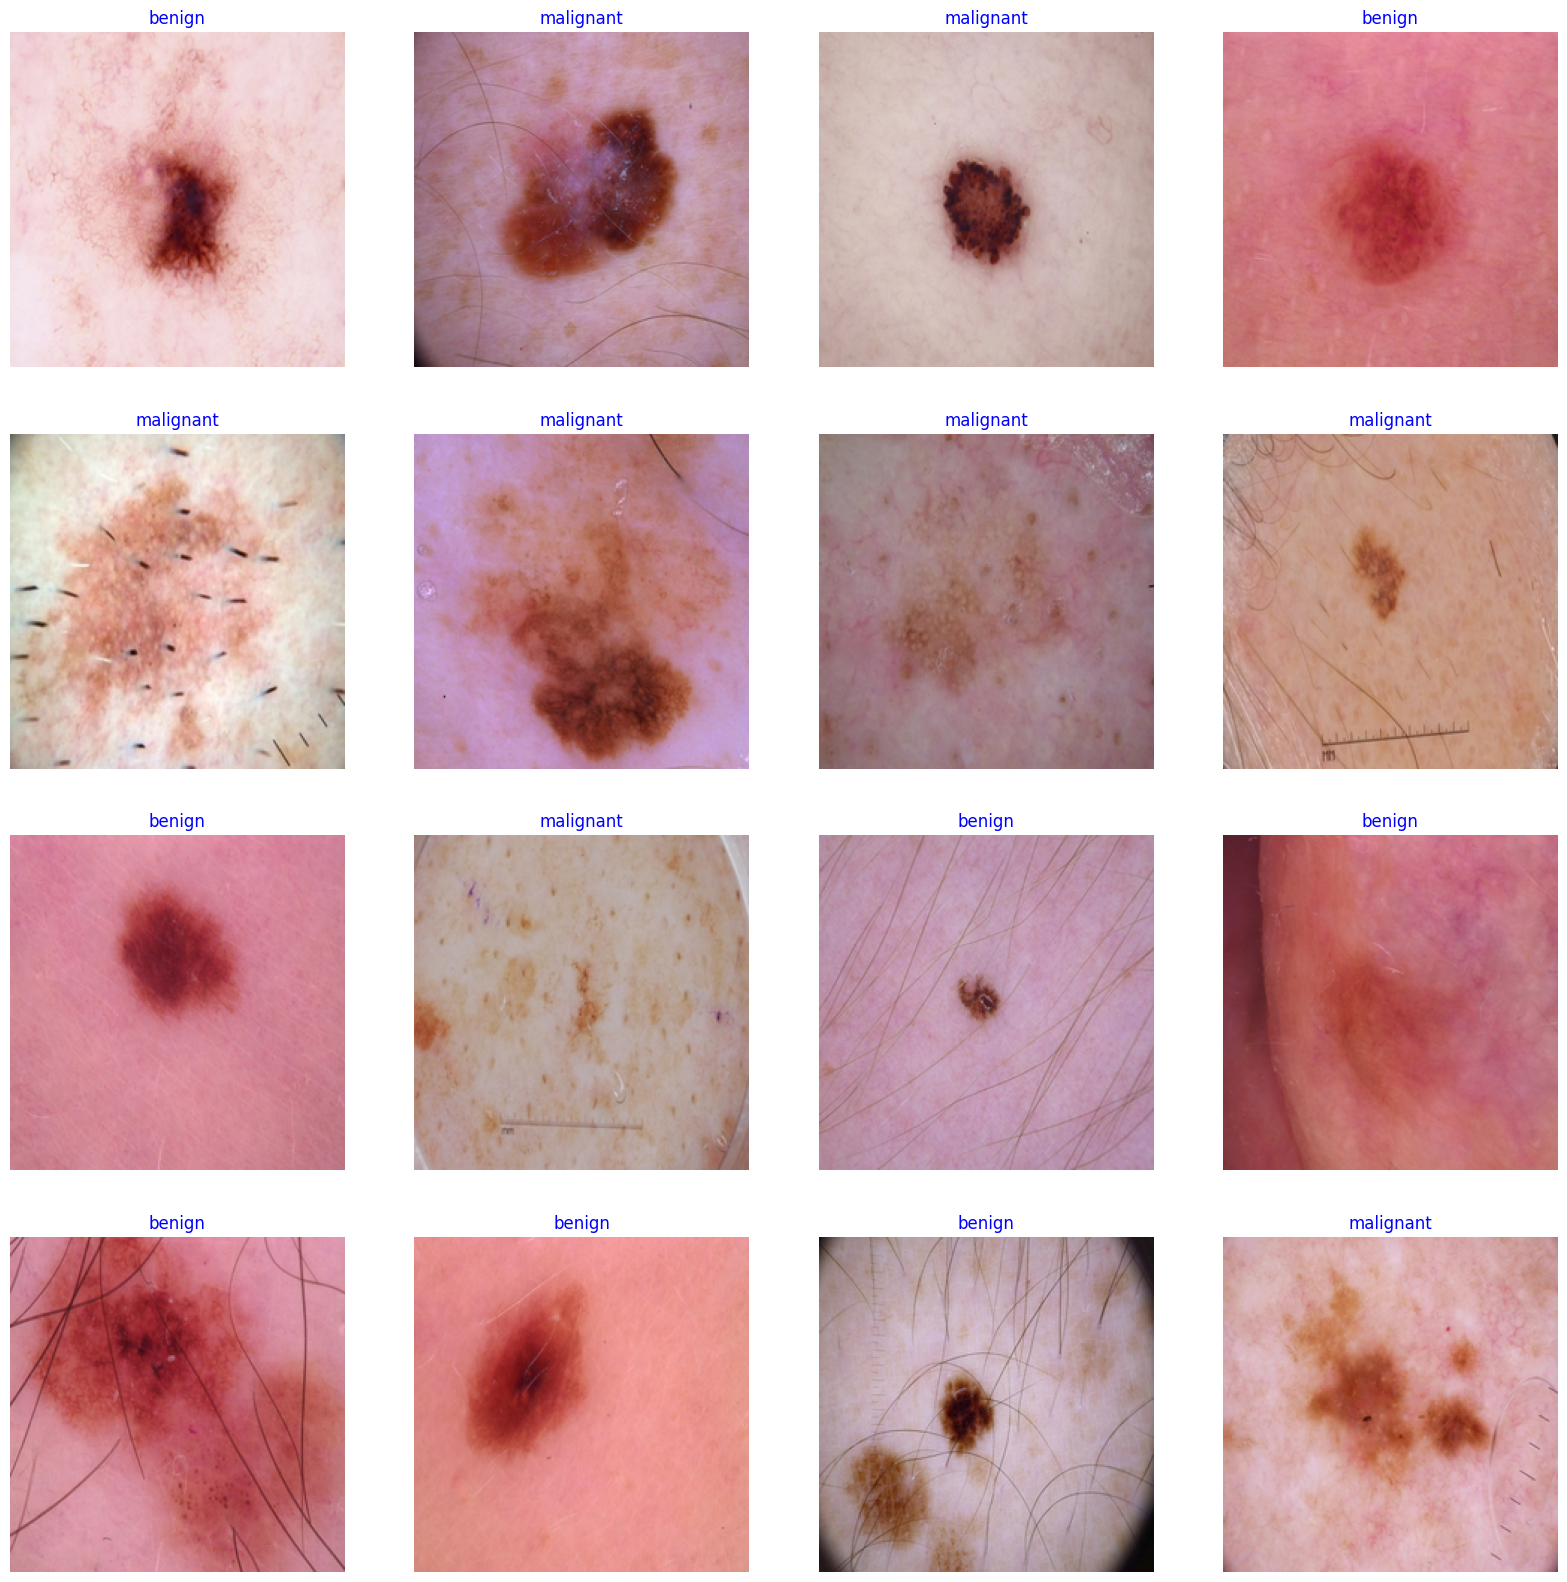

In [9]:
# sample 
g_dict = train_gen.class_indices       
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

# **Modeling**

In [10]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Number of classes in the dense layer
class_count = len(list(train_gen.class_indices.keys())) 

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(class_count, activation="softmax")
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='img_paths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = valid_datagen.flow_from_dataframe(valid_df, x_col='img_paths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=1e-7)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,170,946 (80.76 MB)

 Trainable params: 21,162,498 (80.73 MB)

 Non-trainable params: 8,448 (33.00 KB)

Found 2637 validated image filenames belonging to 2 classes.
Found 1318 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
tf.config.optimizer.set_jit(False)  # Disable XLA JIT
#check mtnseshhh (the version >>cuda)

In [15]:
history = model.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle = False) 

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.7628 - loss: 0.5246 - val_accuracy: 0.7944 - val_loss: 0.6472
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7901 - loss: 0.4551 - val_accuracy: 0.8323 - val_loss: 0.3669
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.7458 - loss: 0.5242 - val_accuracy: 0.8194 - val_loss: 0.3547
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.7634 - loss: 0.5325 - val_accuracy: 0.8073 - val_loss: 0.4591
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.7891 - loss: 0.4701 - val_accuracy: 0.7989 - val_loss: 0.9022
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7812 - loss: 0.4663 - val_accuracy: 0.8217 - val_loss: 0.5142
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.7805 - loss: 0.4931 - val_accuracy: 0.8217 - val_loss: 0.4196
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.7822 - loss: 0

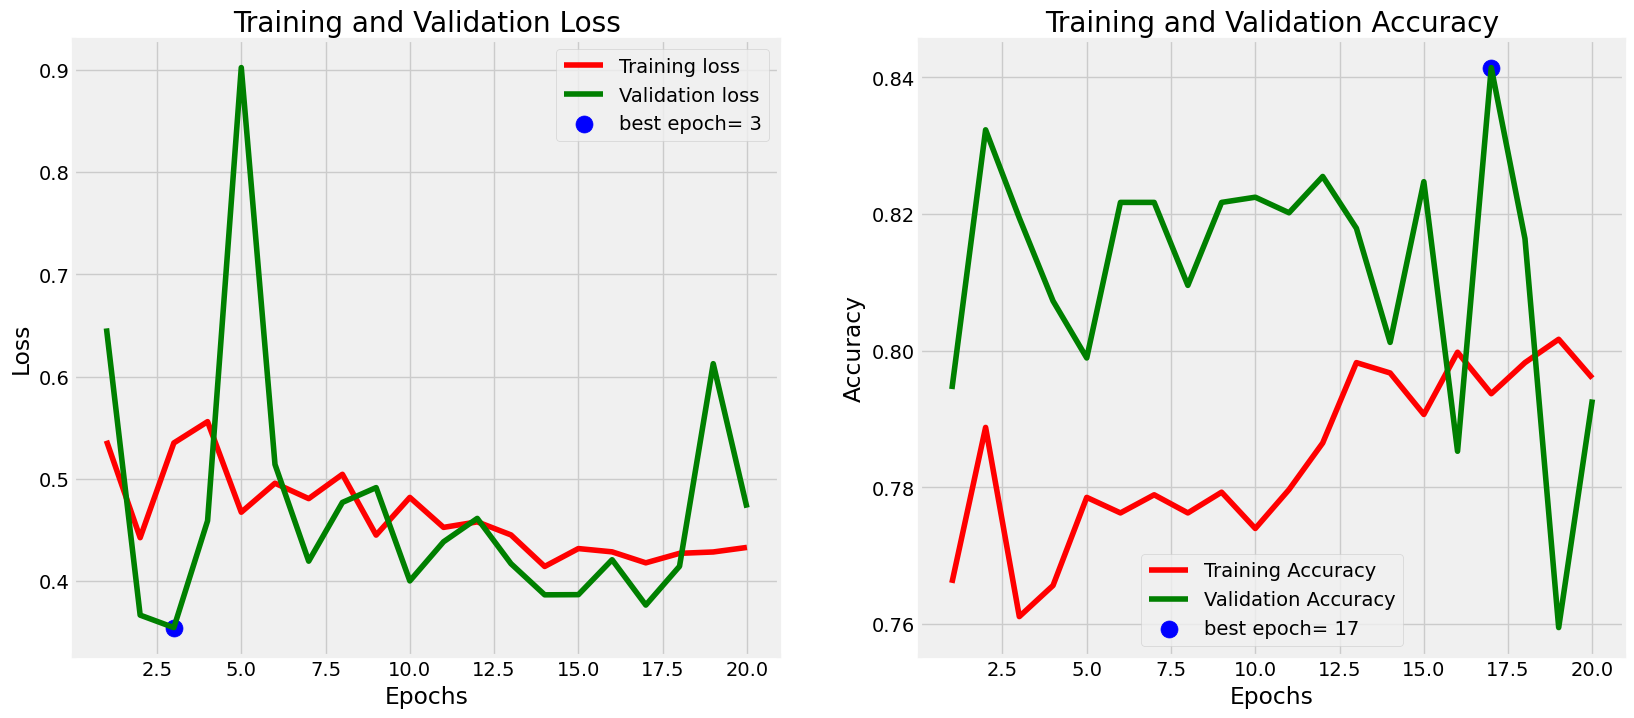

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluation**

In [18]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen )
test_score = model.evaluate(test_gen )

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.7800 - loss: 0.4563
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7587 - loss: 0.5029
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7631 - loss: 0.4904
Train Loss:  0.4710919260978699
Train Accuracy:  0.7808115482330322
--------------------
Validation Loss:  0.5049235820770264
Validation Accuracy:  0.7928679585456848
--------------------
Test Loss:  1.8012768030166626
Test Accuracy:  0.7649734616279602


# **Predictions**

In [20]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


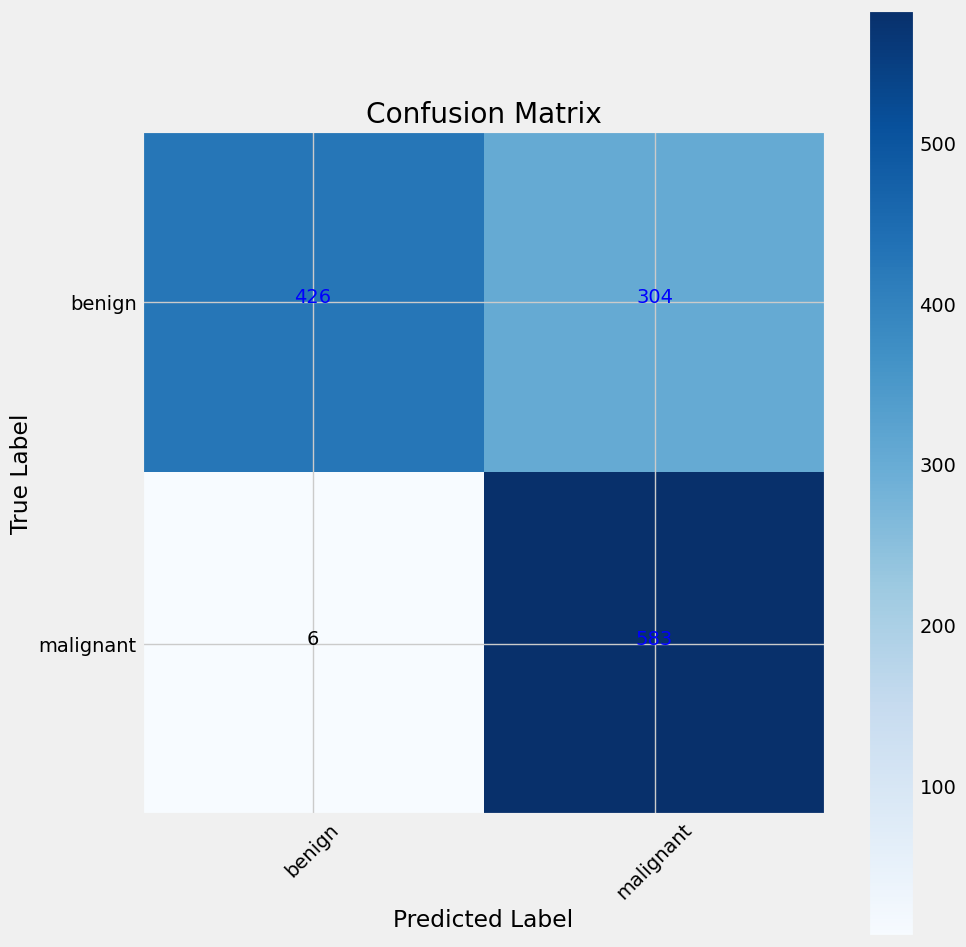

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'blue' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
print(classification_report(test_gen.classes, y_pred, target_names= classes)) 

              precision    recall  f1-score   support

      benign       0.99      0.58      0.73       730
   malignant       0.66      0.99      0.79       589

    accuracy                           0.76      1319
   macro avg       0.82      0.79      0.76      1319
weighted avg       0.84      0.76      0.76      1319

